<a href="https://colab.research.google.com/github/adnan150223/arrythimia_detectionproject/blob/main/FinalArrythimia__detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Machine Learning Project**

# **Group Members:**
 **Muhammad Adnan**

 **Samiullah Saddiuqe**

 **Umair Ejaz**

#**Arythimia Detection System**

#**Arrhythmia Detection Overview**
**What is Arrhythmia?**

Arrhythmia is an irregular heartbeat that can be:

Too fast (Tachycardia)

Too slow (Bradycardia)

Irregular or skipped beats

It can impact the heart's efficiency, leading to complications like stroke, heart failure, or sudden cardiac arrest.

#**Types of Arrhythmias:**
**N**: Normal Beats

**L**: Left Bundle Branch Block

**R**: Right Bundle Branch Block

**A**: Atrial Premature Beats

**V**: Premature Ventricular Contractions

#**Why Detect Arrhythmias?**
Arrhythmias can be harmless, but they can also be life-threatening if left untreated. They may:

Increase the risk of stroke (e.g., in Atrial Fibrillation).

Lead to heart failure or sudden cardiac arrest.

Cause symptoms like dizziness, fatigue, shortness of breath, or fainting.

#**ECG Analysis:**
The Electrocardiogram (ECG) records heart activity and helps detect arrhythmias through:

**RR-Intervals:** Time between consecutive R-peaks.

**QRS Complex:** Ventricular activity.

**Amplitude:** Signal strength to identify abnormal beats.

#**Why Machine Learning?**
Automates arrhythmia detection.

Reduces manual analysis.

Enables real-time and accurate diagnosis.

By extracting key features from ECG signals and applying machine learning models, we can improve early detection and save lives.



#**Import Dataset**

In [ ]:
!pip install wfdb matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
!mkdir -p mitdb

In [ ]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/ -P mitdb/


Streaming output truncated to the last 5000 lines.
Length: 5468 (5.3K) [application/octet-stream]
Saving to: ‘mitdb/physionet.org/files/mitdb/1.0.0/223.atr’

physionet.org/files 100%[===================>]   5.34K  --.-KB/s    in 0s      

2024-12-22 10:44:51 (5.51 GB/s) - ‘mitdb/physionet.org/files/mitdb/1.0.0/223.atr’ saved [5468/5468]

--2024-12-22 10:44:51--  https://physionet.org/files/mitdb/1.0.0/223.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1950000 (1.9M) [application/octet-stream]
Saving to: ‘mitdb/physionet.org/files/mitdb/1.0.0/223.dat’

physionet.org/files 100%[===================>]   1.86M   604KB/s    in 3.2s    

2024-12-22 10:44:55 (604 KB/s) - ‘mitdb/physionet.org/files/mitdb/1.0.0/223.dat’ saved [1950000/1950000]

--2024-12-22 10:44:55--  https://physionet.org/files/mitdb/1.0.0/223.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 258 [text/plain

In [ ]:
!ls mitdb/physionet.org/files/mitdb/1.0.0/

100.atr    105.atr  111.atr  116.dat  122.atr  202.dat	209.at_  214.xws  221.xws  231.xws
100.dat    105.dat  111.dat  116.hea  122.dat  202.hea	209.atr  215.at_  222.at_  232.atr
100.hea    105.hea  111.hea  116.xws  122.hea  202.xws	209.dat  215.atr  222.atr  232.dat
100.xws    105.xws  111.xws  117.at_  122.xws  203.at-	209.hea  215.dat  222.dat  232.hea
101.atr    106.atr  112.atr  117.atr  123.atr  203.at_	209.xws  215.hea  222.hea  232.xws
101.dat    106.dat  112.dat  117.dat  123.dat  203.atr	210.atr  215.xws  222.xws  233.atr
101.hea    106.hea  112.hea  117.hea  123.hea  203.dat	210.dat  217.atr  223.atr  233.dat
101.xws    106.xws  112.xws  117.xws  123.xws  203.hea	210.hea  217.dat  223.dat  233.hea
102-0.atr  107.atr  113.atr  118.atr  124.atr  203.xws	210.xws  217.hea  223.hea  233.xws
102.atr    107.dat  113.dat  118.dat  124.dat  205.atr	212.atr  217.xws  223.xws  234.atr
102.dat    107.hea  113.hea  118.hea  124.hea  205.dat	212.dat  219.atr  228.atr  234.dat
102.hea   

# **Import Libraries:**

In [ ]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


# **Ploting ECG Signal:**

In [ ]:


# Step 1: Plot Raw Signal
def plot_raw_signal(record_path, title="Raw ECG Signal"):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal
    time = np.arange(0, len(signal)) / record.fs

    plt.figure(figsize=(15, 5))
    plt.plot(time, signal[:, 0], label="Channel 1 (Lead II)")
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.show()



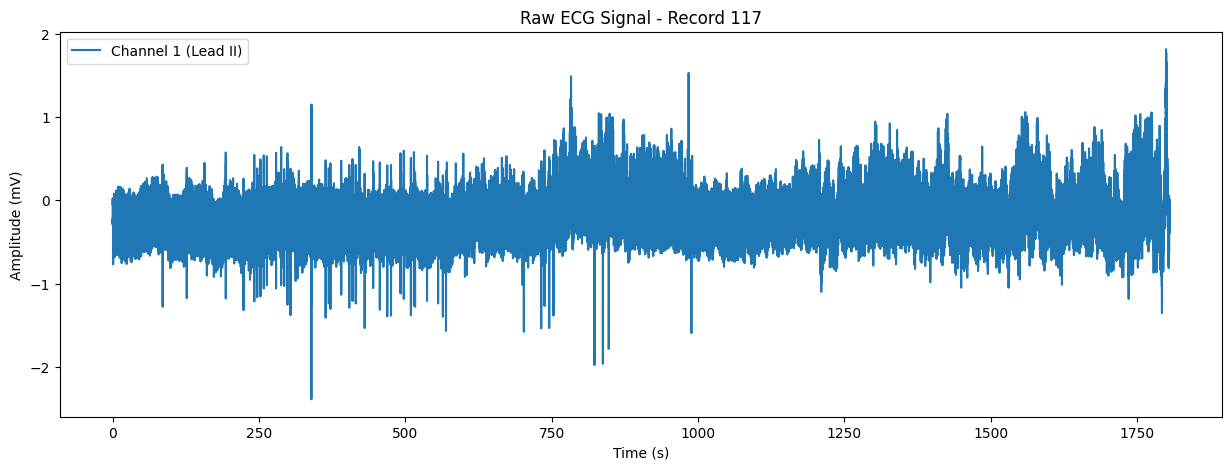

In [ ]:
plot_raw_signal(record_paths[0], title="Raw ECG Signal - Record 117")

#**Filtering Signal:**

In [ ]:
# Bandpass Filter Function
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=50.0, fs=360, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data, axis=0)
    return y

# Signal Normalization Function
def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

# Signal Segmentation Function
def segment_signal(signal, fs, segment_length=30):
    """
    Break signal into fixed-length segments.
    Args:
        signal: ECG signal data.
        fs: Sampling frequency.
        segment_length: Length of each segment in seconds.
    Returns:
        List of segments.
    """
    samples_per_segment = fs * segment_length
    num_segments = len(signal) // samples_per_segment
    return [signal[i * samples_per_segment: (i + 1) * samples_per_segment] for i in range(num_segments)]


In [ ]:
def bandpass_filter(signal, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def plot_filtered_signal(record_path, lowcut=0.5, highcut=50, title="Filtered ECG Signal"):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # Channel 1
    fs = record.fs
    filtered_signal = bandpass_filter(signal, lowcut, highcut, fs)

    time = np.arange(0, len(signal)) / fs
    plt.figure(figsize=(15, 5))
    plt.plot(time, signal, label="Raw Signal", alpha=0.6)
    plt.plot(time, filtered_signal, label="Filtered Signal", linewidth=2)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.show()

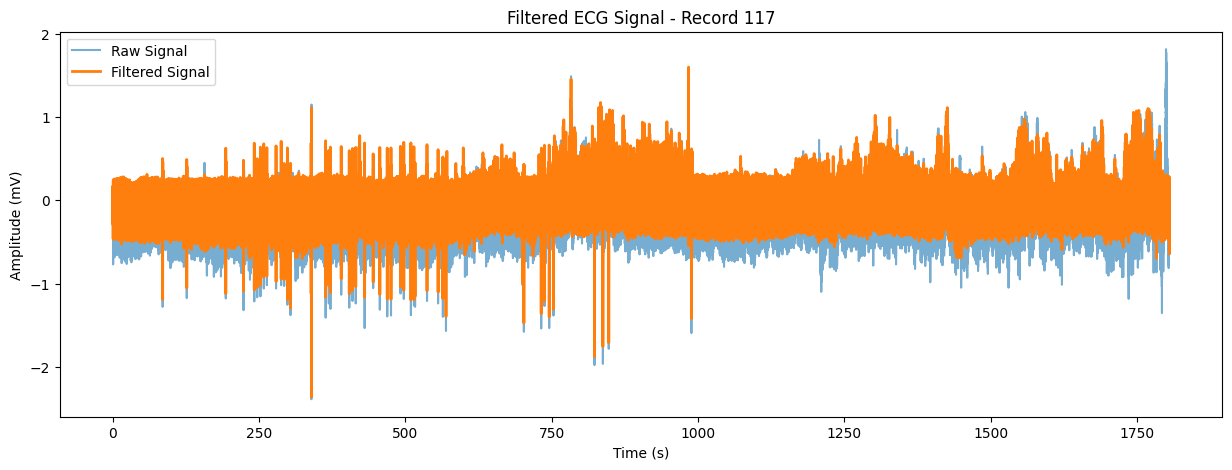

In [ ]:
plot_filtered_signal(record_paths[0], title="Filtered ECG Signal - Record 117")


#**Filtering & Normalizing all Signals:**

In [ ]:
import os
import numpy as np
import pandas as pd
import wfdb
from scipy.signal import butter, filtfilt

# Bandpass filter for preprocessing
def bandpass_filter(signal, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Signal normalization function
def normalize_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

# Segment the signal into fixed lengths
def segment_signal(signal, fs, segment_length):
    num_samples = fs * segment_length
    return [signal[i:i+num_samples] for i in range(0, len(signal), num_samples) if len(signal[i:i+num_samples]) == num_samples]


#**Feature Extraction:**

In [ ]:
def extract_segment_features(segment, fs, annotation, start_idx, end_idx):
    """
    Extract features for a single ECG segment.

    Args:
        segment (np.array): The ECG segment.
        fs (int): Sampling frequency.
        annotation (wfdb.Annotation): Annotations for the ECG record.
        start_idx (int): Start index of the segment.
        end_idx (int): End index of the segment.

    Returns:
        dict: Extracted features.
    """
    # Extract R-peaks within the segment
    r_peaks = [sample for sample in annotation.sample if start_idx <= sample < end_idx]
    rr_intervals = np.diff(r_peaks) / fs if len(r_peaks) > 1 else []

    # Check if RR intervals exist
    rr_mean = np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
    rr_std = np.std(rr_intervals) if len(rr_intervals) > 0 else 0

    # Safely handle segment features
    r_peak_amplitude = np.max(segment) if segment.size > 0 else 0
    segment_power = np.mean(np.square(segment)) if segment.size > 0 else 0  # Power of the signal
    segment_variance = np.var(segment) if segment.size > 0 else 0

    return {
        'RR_Interval_Mean': rr_mean,
        'RR_Interval_STD': rr_std,
        'R_Peak_Amplitude': r_peak_amplitude,
        'Signal_Power': segment_power,
        'Signal_Variance': segment_variance
    }


In [ ]:


# Process a single ECG record
def process_record(record_path, segment_length, lowcut=0.5, highcut=50):
    try:
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')
        fs = record.fs

        signal = record.p_signal[:, 0]  # Use channel 1 (Lead II)
        filtered_signal = bandpass_filter(signal, lowcut=lowcut, highcut=highcut, fs=fs)
        normalized_signal = normalize_signal(filtered_signal)

        segments = segment_signal(normalized_signal, fs, segment_length)

        labeled_segments = []
        for i, segment in enumerate(segments):
            start_idx = i * fs * segment_length
            end_idx = start_idx + len(segment)

            annotations_in_segment = [
                symbol for j, symbol in enumerate(annotation.symbol)
                if start_idx <= annotation.sample[j] < end_idx
            ]

            label = max(set(annotations_in_segment), key=annotations_in_segment.count) if annotations_in_segment else -1

            features = extract_segment_features(segment, fs, annotation, start_idx, end_idx)
            labeled_segments.append({
                'Record': record_path.split('/')[-1],
                'Segment': i + 1,
                **features,
                'Label': label
            })

        return pd.DataFrame(labeled_segments)
    except Exception as e:
        print(f"Error processing record {record_path}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

# Get all record paths from the dataset directory
def get_all_record_paths(base_path):
    record_paths = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.dat'):  # Only process .dat files
                record_name = file.split('.')[0]
                record_paths.append(os.path.join(root, record_name))
    return record_paths

# Main script to process all records
if __name__ == "__main__":
    # Base directory of your MIT-BIH dataset
    base_directory = "/content/mitdb/physionet.org/files/mitdb/1.0.0"

    # Dynamically get all record paths
    record_paths = get_all_record_paths(base_directory)
    print(f"Found {len(record_paths)} records.")

    all_records_data = []

    for record_path in record_paths:
        print(f"Processing record: {record_path}")
        record_data = process_record(record_path, segment_length=30)
        if not record_data.empty:
            all_records_data.append(record_data)

    if all_records_data:
        # Combine into a single DataFrame
        final_dataset = pd.concat(all_records_data, ignore_index=True)

        # Save to CSV
        final_dataset.to_csv("ecg_processed_labeled_dataset.csv", index=False)
        print("Combined dataset saved to 'ecg_processed_labeled_dataset.csv'.")
        print(final_dataset.head())
    else:
        print("No data was processed successfully.")


Found 71 records.
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/114
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/104
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/109
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/205
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/121
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/117
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/212
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/111
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/123
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/101
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/233
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/119
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/220
Processing record: /content/mitdb/physionet.org/files/mitdb/1.0.0/115
Pr

In [ ]:
import pandas
final_dataset = pd.read_csv("ecg_processed_labeled_dataset.csv")


#**Feature Ploting:**

In [ ]:
def plot_rr_intervals(rr_intervals, record_id):
    plt.figure(figsize=(12, 5))
    plt.plot(rr_intervals, 'o-', label='RR Intervals')
    plt.title(f"RR Intervals for Record: {record_id}")
    plt.xlabel("Beat Index")
    plt.ylabel("Interval (s)")
    plt.legend()
    plt.show()



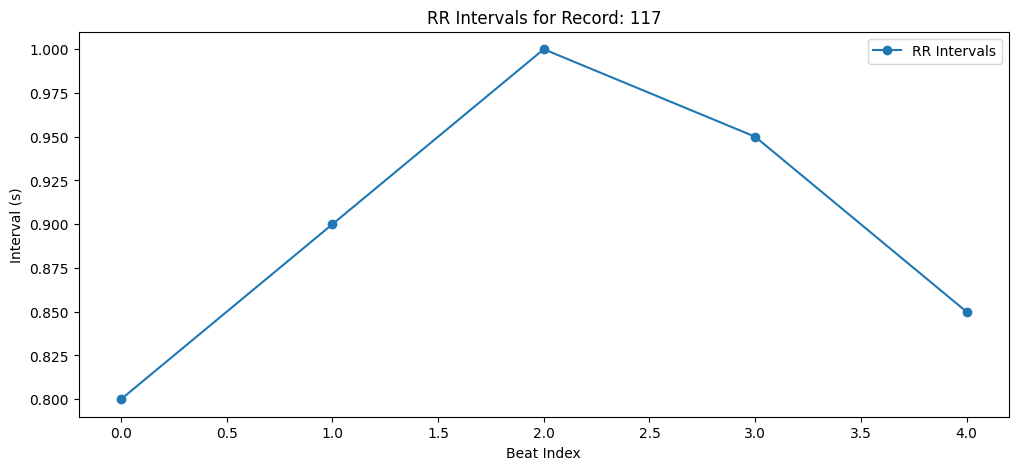

In [ ]:


rr_intervals_example = [0.8, 0.9, 1.0, 0.95, 0.85]  # Example RR Intervals
r_peak_amplitudes_example = [0.5, 0.6, 0.55, 0.7, 0.65]  # Example R-Peak Amplitudes

plot_rr_intervals(rr_intervals_example, record_id=117)


In [ ]:
def plot_rpeak_amplitudes(r_peak_amplitudes, record_id):
    plt.figure(figsize=(12, 5))
    plt.plot(r_peak_amplitudes, 'o-', label='R-Peak Amplitudes')
    plt.title(f"R-Peak Amplitudes for Record: {record_id}")
    plt.xlabel("Beat Index")
    plt.ylabel("Amplitude (Normalized)")
    plt.legend()
    plt.show()

# Step 4: Class Distribution Plot
def plot_class_distribution(labels):
    label_counts = labels.value_counts()
    plt.figure(figsize=(8, 5))
    plt.bar(label_counts.index, label_counts.values)
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Frequency")
    plt.show()


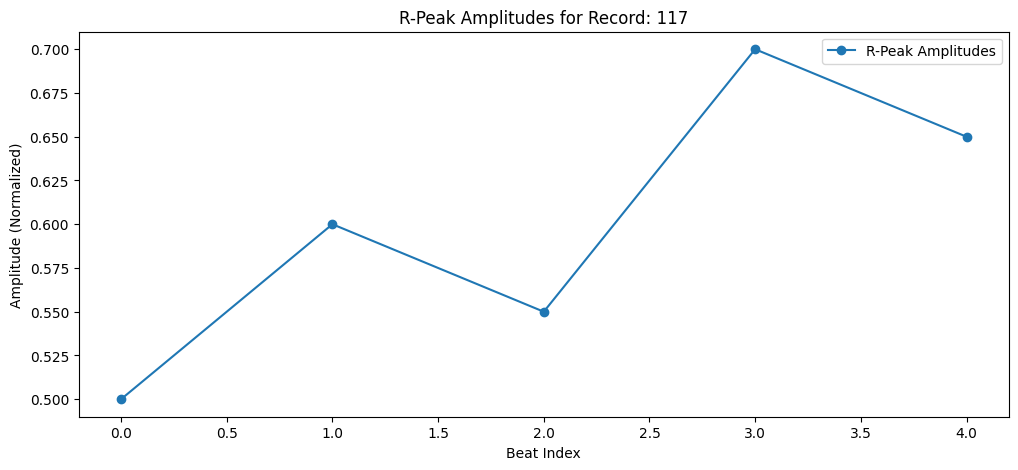

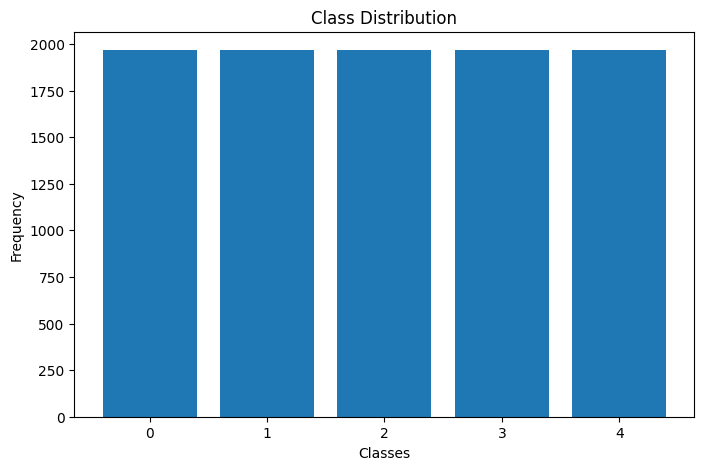

In [ ]:
plot_rpeak_amplitudes(r_peak_amplitudes_example, record_id=117)

# Plot 3: Class Distribution
plot_class_distribution(y)


In [ ]:
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

# **Data Cleaning:**

In [ ]:
import pandas as pd
final_dataset = pd.read_csv("ecg_processed_labeled_dataset.csv")


In [ ]:
final_dataset.head()

,Record,Segment,RR_Interval_Mean,RR_Interval_STD,R_Peak_Amplitude,Signal_Power,Signal_Variance,Label
0,114,1,1.098354,0.069291,2.337294,0.698934,0.698923,N
1,114,2,1.099359,0.043855,2.587558,0.722423,0.722403,N
2,114,3,1.065123,0.150986,4.166712,0.897890,0.897886,N
3,114,4,1.082819,0.036766,2.226709,0.751938,0.751936,N
4,114,5,1.098611,0.156793,4.074654,0.958330,0.958322,N


In [ ]:
print(final_dataset['Label'].value_counts())


Label
N    2459
L     263
R     229
/     219
A      87
V      40
"      25
f       7
!       7
E       3
J       1
Name: count, dtype: int64


In [ ]:
# Keep only relevant labels
relevant_labels = ['N', 'L', 'R', 'A', 'V']
cleaned_dataset = final_dataset[final_dataset['Label'].isin(relevant_labels)]

# Display cleaned dataset label distribution
print("Cleaned Label Distribution:")
print(cleaned_dataset['Label'].value_counts())


Cleaned Label Distribution:
Label
N    2459
L     263
R     229
A      87
V      40
Name: count, dtype: int64


#**Fixing Imbalance Data:**

In [ ]:
pip install imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 4.9 MB/s eta 0:00:00


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Clean the dataset (keep only relevant labels)
relevant_labels = ['N', 'L', 'R', 'A', 'V']
cleaned_dataset = final_dataset[final_dataset['Label'].isin(relevant_labels)]

# Step 2: Convert labels to numerical format for SMOTE
label_mapping = {'N': 0, 'L': 1, 'R': 2, 'A': 3, 'V': 4}
cleaned_dataset['Label'] = cleaned_dataset['Label'].map(label_mapping)

# Step 3: Separate features and labels
X = cleaned_dataset[['RR_Interval_Mean', 'R_Peak_Amplitude']]  # Features
y = cleaned_dataset['Label']  # Target

# Step 4: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Apply SMOTE for oversampling the minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Step 6: Verify the new label distribution
print("Original Training Label Distribution:")
print(y_train.value_counts())

print("\nResampled Training Label Distribution:")
print(pd.Series(y_resampled).value_counts())


Original Training Label Distribution:
Label
0    1967
1     210
2     183
3      70
4      32
Name: count, dtype: int64

Resampled Training Label Distribution:
Label
0    1967
1    1967
3    1967
2    1967
4    1967
Name: count, dtype: int64


<ipython-input-29-3b79f32027b8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataset['Label'] = cleaned_dataset['Label'].map(label_mapping)


#**Model Traning:**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

Class distribution after SMOTE:
Label
0    1967
1    1967
3    1967
2    1967
4    1967
Name: count, dtype: int64
Training Logistic Regression...


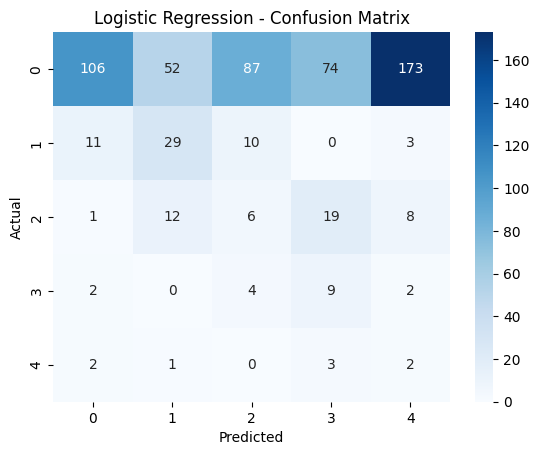

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.22      0.35       492
           1       0.31      0.55      0.39        53
           2       0.06      0.13      0.08        46
           3       0.09      0.53      0.15        17
           4       0.01      0.25      0.02         8

    accuracy                           0.25       616
   macro avg       0.27      0.33      0.20       616
weighted avg       0.73      0.25      0.32       616

Training Random Forest...


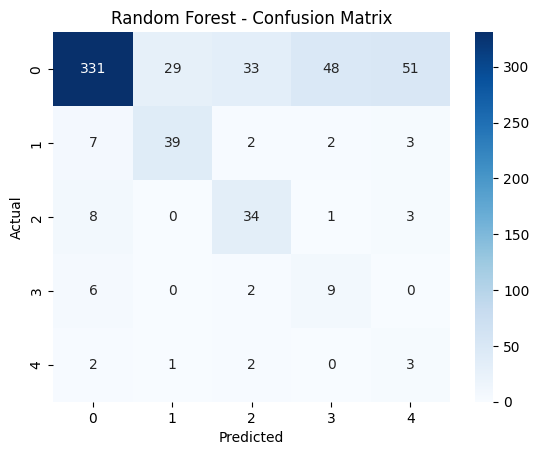

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.67      0.78       492
           1       0.57      0.74      0.64        53
           2       0.47      0.74      0.57        46
           3       0.15      0.53      0.23        17
           4       0.05      0.38      0.09         8

    accuracy                           0.68       616
   macro avg       0.43      0.61      0.46       616
weighted avg       0.84      0.68      0.73       616

Training SVM...


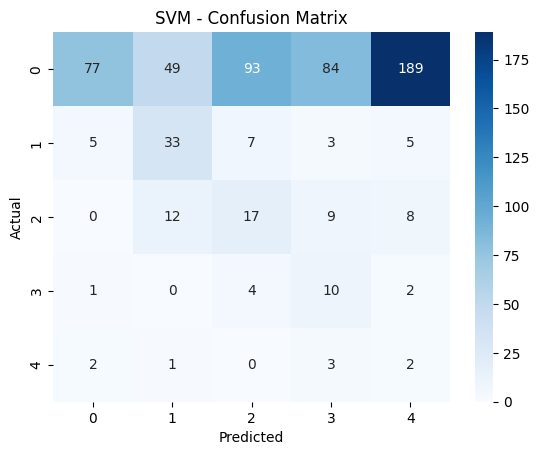

SVM Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.16      0.27       492
           1       0.35      0.62      0.45        53
           2       0.14      0.37      0.20        46
           3       0.09      0.59      0.16        17
           4       0.01      0.25      0.02         8

    accuracy                           0.23       616
   macro avg       0.30      0.40      0.22       616
weighted avg       0.77      0.23      0.27       616

Model Performance Summary:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.246753   0.727189  0.246753  0.319914
1        Random Forest  0.675325   0.835008  0.675325  0.730266
2                  SVM  0.225649   0.766566  0.225649  0.271367


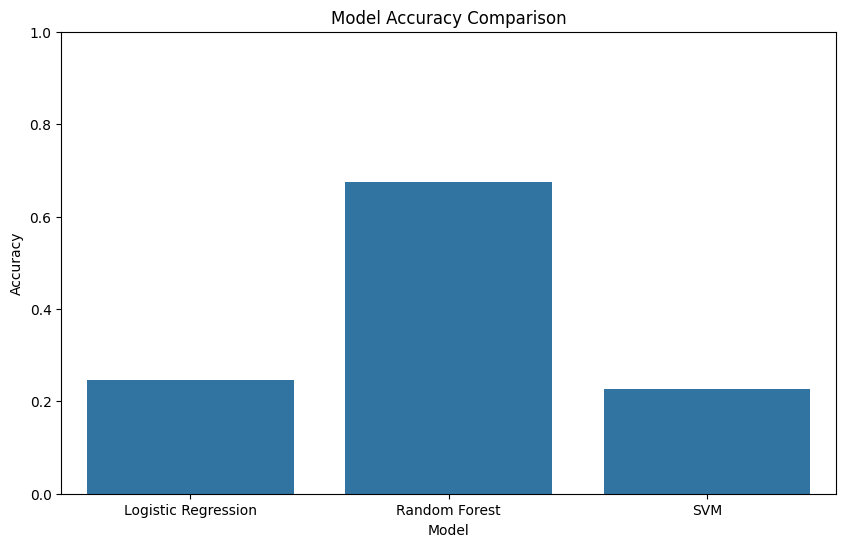

In [ ]:

# Step 1: Split the original data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Apply SMOTE to balance the training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y).value_counts())

# Step 3: Initialize Models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=500),  # Increased max_iter
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "SVM": SVC(random_state=42, kernel='linear', probability=True)
}

# Step 4: Train and Evaluate Models
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X, y)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # Adjusted for multiclass
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

    print(f"{name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

# Step 5: Generate Report
results_df = pd.DataFrame(results)
print("Model Performance Summary:")
print(results_df)

# Save results to CSV
results_df.to_csv("model_performance_report.csv", index=False)

# Plot Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.show()


#**Hyperparameter Tunning:**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for each model
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1, 10, 100],  # Regularization strength
        'solver': ['liblinear', 'lbfgs']  # Solvers
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200, 500],  # Number of trees
        'max_depth': [10, 20, 30, None],  # Maximum depth of trees
        'min_samples_split': [2, 5, 10],  # Minimum samples required to split
        'min_samples_leaf': [1, 2, 4]  # Minimum samples at leaf nodes
    },
    "Decision Tree": {
        'criterion': ['gini', 'entropy'],  # Splitting criteria
        'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum samples required to split
        'min_samples_leaf': [1, 2, 4]  # Minimum samples at leaf nodes
    }
}


Running RandomizedSearchCV for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Best parameters for Logistic Regression: {'solver': 'lbfgs', 'C': 1}


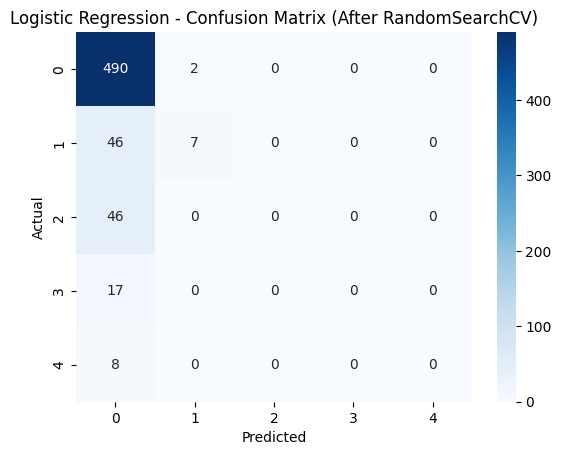

Logistic Regression Classification Report (After RandomSearchCV):

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       492
           1       0.78      0.13      0.23        53
           2       0.00      0.00      0.00        46
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         8

    accuracy                           0.81       616
   macro avg       0.32      0.23      0.22       616
weighted avg       0.71      0.81      0.73       616

Running RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


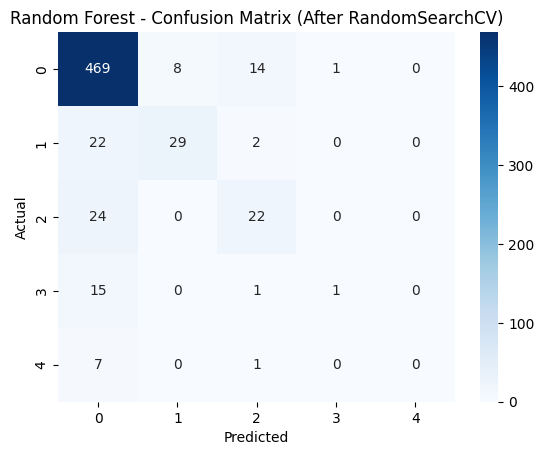

Random Forest Classification Report (After RandomSearchCV):

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       492
           1       0.78      0.55      0.64        53
           2       0.55      0.48      0.51        46
           3       0.50      0.06      0.11        17
           4       0.00      0.00      0.00         8

    accuracy                           0.85       616
   macro avg       0.54      0.41      0.43       616
weighted avg       0.82      0.85      0.82       616

Running RandomizedSearchCV for Decision Tree...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters for Decision Tree: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'entropy'}


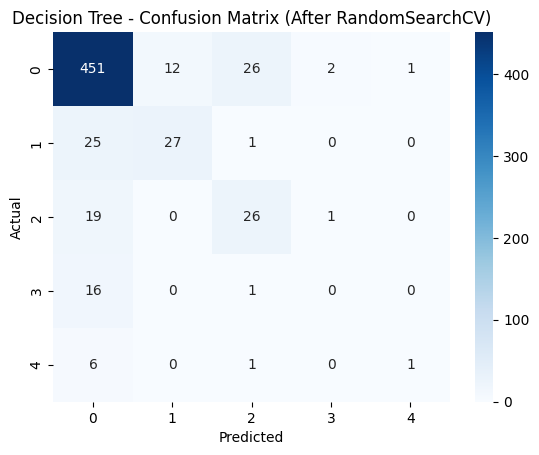

Decision Tree Classification Report (After RandomSearchCV):

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       492
           1       0.69      0.51      0.59        53
           2       0.47      0.57      0.51        46
           3       0.00      0.00      0.00        17
           4       0.50      0.12      0.20         8

    accuracy                           0.82       616
   macro avg       0.51      0.42      0.44       616
weighted avg       0.80      0.82      0.81       616


Final Results:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.806818   0.711670  0.806818  0.731646
1        Random Forest  0.845779   0.819868  0.845779  0.824626
2        Decision Tree  0.819805   0.798099  0.819805  0.805548

Final Results:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.806818   0.711670  0.806818  0.731646
1        Random Forest  0.845779  

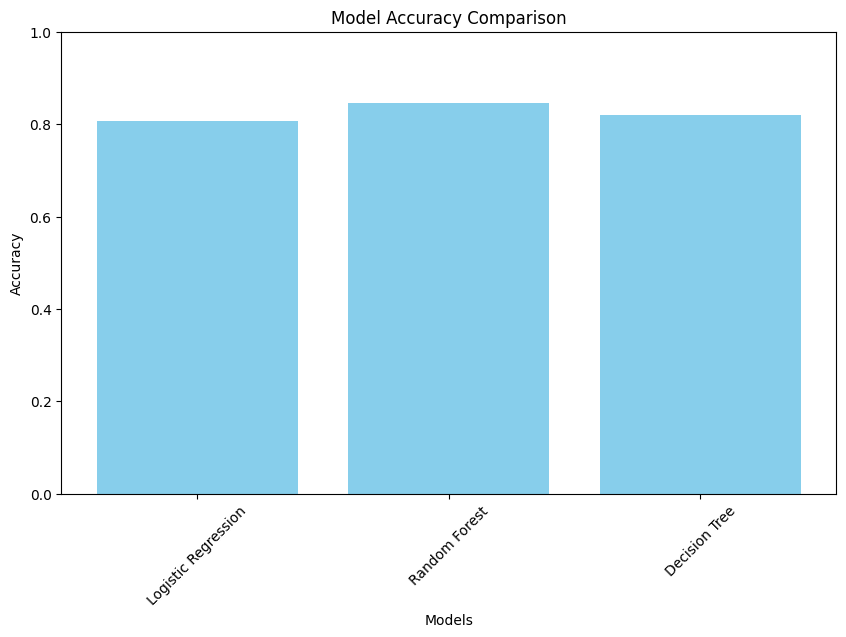

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

# Define models to evaluate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Results storage
results = []

for name, model in models.items():
    print(f"Running RandomizedSearchCV for {name}...")

    # Get hyperparameter grid for the model
    param_grid = param_grids[name]

    # Define scorer for RandomizedSearchCV
    scorer = make_scorer(f1_score, average='weighted')

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring=scorer,
        n_iter=20,  # Number of parameter settings sampled
        cv=5,  # 5-fold cross-validation
        verbose=1,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit the model
    random_search.fit(X_train, y_train)

    # Best model and parameters
    best_model = random_search.best_estimator_
    print(f"Best parameters for {name}: {random_search.best_params_}")

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix (After RandomSearchCV)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Append results
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

    # Classification Report
    print(f"{name} Classification Report (After RandomSearchCV):\n")
    print(classification_report(y_test, y_pred))

# Display final results
results_df = pd.DataFrame(results)
print("\nFinal Results:")


print(results_df)
# Function to plot accuracies of all models
def plot_all_model_accuracies(results_df):
    plt.figure(figsize=(10, 6))
    plt.bar(results_df['Model'], results_df['Accuracy'], color='skyblue')
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.xlabel("Models")
    plt.ylim(0, 1)  # Accuracy scale from 0 to 1
    plt.xticks(rotation=45)
    plt.show()

# Display final results
results_df = pd.DataFrame(results)  # Ensure this comes from your RandomizedSearchCV results
print("\nFinal Results:")
print(results_df)

# Plot accuracies of all models
plot_all_model_accuracies(results_df)



#**Thank You**

********************************************************************************